<a href="https://colab.research.google.com/github/rammafitra/PyTorch_Instance_Segmentation/blob/main/MaskRCNN_ResNet50_FPN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
url = "https://drive.google.com/uc?id=11DMbQaHpPB6aS8MAYusKQlg_YBMQ7GbT&export=download"
r = requests.get(url)
print(r)
with open('input.zip', 'wb') as f:
   f.write(r.content)



<Response [200]>


In [2]:
!unzip /content/input.zip

Archive:  /content/input.zip
   creating: input_car/
  inflating: input_car/1_4_4140_1660_1695_1_0_18.png  
  inflating: input_car/1_4_4200_1660_1695_1_0_50.png  
  inflating: input_car/1_4_4835_1815_1910_1_0_68.png  
  inflating: input_car/1_4_4300_1700_1460_0_1_42.png  
  inflating: input_car/1_4_3995_1635_1490_1_1_40.png  


In [3]:
!mkdir /content/outputs



In [4]:
%%writefile coco_names.py
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

Writing coco_names.py


In [5]:
%%writefile utils.py
import cv2
import numpy as np
import random
import torch
from coco_names import COCO_INSTANCE_CATEGORY_NAMES as coco_names


# this will help us create a different color for each class
COLORS = np.random.uniform(0, 255, size=(len(coco_names), 3))
def get_outputs(image, model, threshold):
    with torch.no_grad():
        # forward pass of the image through the modle
        outputs = model(image)
    
    # get all the scores
    scores = list(outputs[0]['scores'].detach().cpu().numpy())
    # index of those scores which are above a certain threshold
    thresholded_preds_inidices = [scores.index(i) for i in scores if i > threshold]
    thresholded_preds_count = len(thresholded_preds_inidices)
    # get the masks
    masks = (outputs[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    # discard masks for objects which are below threshold
    masks = masks[:thresholded_preds_count]
    # get the bounding boxes, in (x1, y1), (x2, y2) format
    boxes = [[(int(i[0]), int(i[1])), (int(i[2]), int(i[3]))]  for i in outputs[0]['boxes'].detach().cpu()]
    # discard bounding boxes below threshold value
    boxes = boxes[:thresholded_preds_count]
    # get the classes labels
    labels = [coco_names[i] for i in outputs[0]['labels']]
    return masks, boxes, labels

def draw_segmentation_map(image, masks, boxes, labels):
    alpha = 1 
    beta = 0.6 # transparency for the segmentation map
    gamma = 0 # scalar added to each sum
    for i in range(len(masks)):
        red_map = np.zeros_like(masks[i]).astype(np.uint8)
        green_map = np.zeros_like(masks[i]).astype(np.uint8)
        blue_map = np.zeros_like(masks[i]).astype(np.uint8)
        # apply a randon color mask to each object
        color = COLORS[random.randrange(0, len(COLORS))]
        red_map[masks[i] == 1], green_map[masks[i] == 1], blue_map[masks[i] == 1]  = color
        # combine all the masks into a single image
        segmentation_map = np.stack([red_map, green_map, blue_map], axis=2)
        #convert the original PIL image into NumPy format
        image = np.array(image)
        # convert from RGN to OpenCV BGR format
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        # apply mask on the image
        cv2.addWeighted(image, alpha, segmentation_map, beta, gamma, image)
        # draw the bounding boxes around the objects
        cv2.rectangle(image, boxes[i][0], boxes[i][1], color=color, 
                      thickness=2)
        # put the label text above the objects
        cv2.putText(image , labels[i], (boxes[i][0][0], boxes[i][0][1]-10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 1, color, 
                    thickness=2, lineType=cv2.LINE_AA)
    
    return image

Writing utils.py


In [6]:
%%writefile mask_rcnn_images.py
import torch
import torchvision
import cv2
import argparse
from PIL import Image
from utils import draw_segmentation_map, get_outputs
from torchvision.transforms import transforms as transforms

parser = argparse.ArgumentParser()
parser.add_argument('-i', '--input', required=True, 
                    help='path to the input data')
parser.add_argument('-t', '--threshold', default=0.965, type=float,
                    help='score threshold for discarding detection')
args = vars(parser.parse_args())

# initialize the model
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True, progress=True, 
                                                           num_classes=91)
# set the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# load the modle on to the computation device and set to eval mode
model.to(device).eval()

# transform to convert the image to tensor
transform = transforms.Compose([
    transforms.ToTensor()
])

image_path = args['input']
image = Image.open(image_path).convert('RGB')
# keep a copy of the original image for OpenCV functions and applying masks
orig_image = image.copy()
# transform the image
image = transform(image)
# add a batch dimension
image = image.unsqueeze(0).to(device)
masks, boxes, labels = get_outputs(image, model, args['threshold'])
result = draw_segmentation_map(orig_image, masks, boxes, labels)
# visualize the image
# cv2.imshow('Segmented image', result)
# cv2.waitKey(0)
# set the save path
save_path = f"outputs/{args['input'].split('/')[-1].split('.')[0]}.png"
cv2.imwrite(save_path, result)



Writing mask_rcnn_images.py


In [7]:
!python mask_rcnn_images.py --input input_car/1_4_3995_1635_1490_1_1_40.png

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100% 170M/170M [00:02<00:00, 77.6MB/s]


In [8]:
!python mask_rcnn_images.py --input input_car/1_4_4140_1660_1695_1_0_18.png

In [9]:
!python mask_rcnn_images.py --input input_car/1_4_4200_1660_1695_1_0_50.png

In [10]:
!python mask_rcnn_images.py --input input_car/1_4_4300_1700_1460_0_1_42.png

Traceback (most recent call last):
  File "mask_rcnn_images.py", line 44, in <module>
    cv2.imwrite(save_path, result)
TypeError: Expected Ptr<cv::UMat> for argument '%s'


In [11]:
!python mask_rcnn_images.py --input input_car/1_4_4835_1815_1910_1_0_68.png

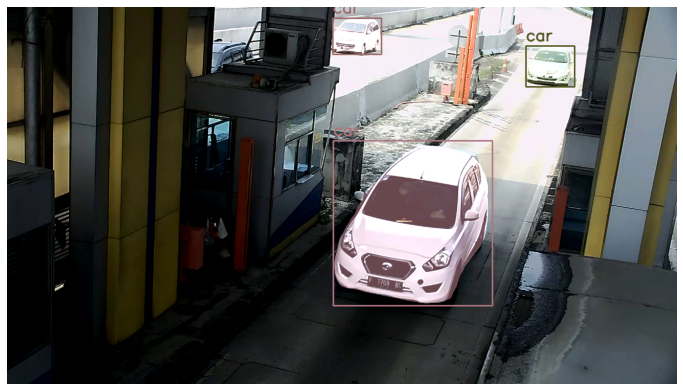

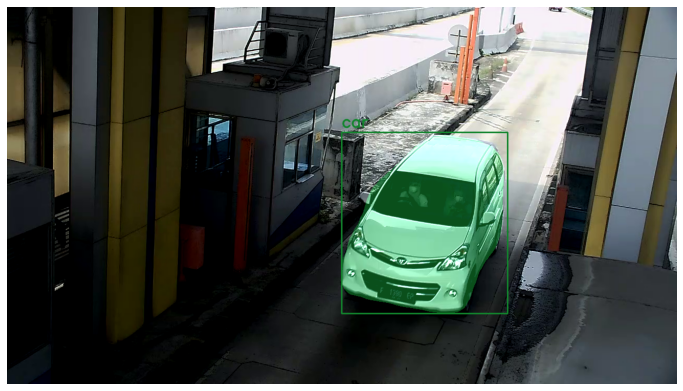

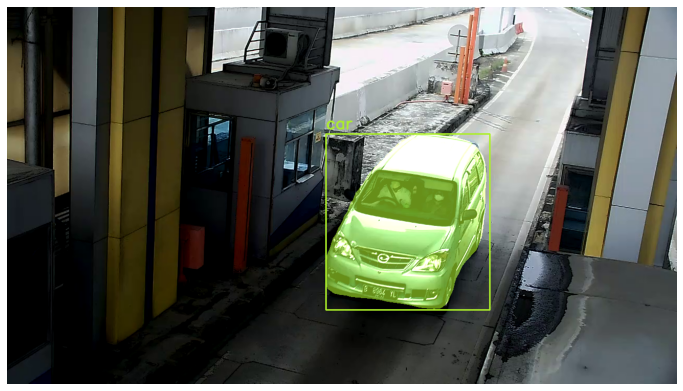

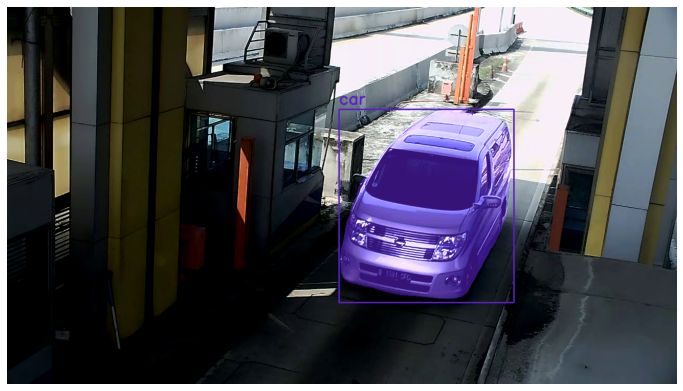

In [12]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['figure.figsize'] = 12, 9

image = plt.imread('outputs/1_4_3995_1635_1490_1_1_40.png')
plt.imshow(image)
plt.axis('off')
plt.show()

image = plt.imread('outputs/1_4_4140_1660_1695_1_0_18.png')
plt.imshow(image)
plt.axis('off')
plt.show()

image = plt.imread('outputs/1_4_4200_1660_1695_1_0_50.png')
plt.imshow(image)
plt.axis('off')
plt.show()

image = plt.imread('outputs/1_4_4835_1815_1910_1_0_68.png')
plt.imshow(image)
plt.axis('off')
plt.show()

#**Comparing inference time for CPU and GPU**



Average Time take by the model with GPU = 0.14775457382202148s
Average Time take by the model with CPU = 7.277520298957825s


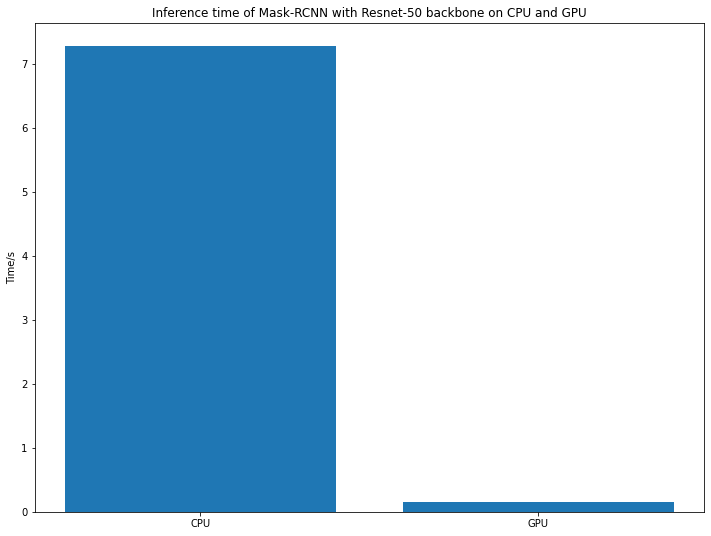

In [13]:
import time
import torch
import torchvision
import cv2
import argparse
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt


def check_inference_time(image_path, gpu=False):
  model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
  model.eval()
  img = Image.open(image_path)
  transform = T.Compose([T.ToTensor()])
  img = transform(img)
  if gpu:
    model.cuda()
    img = img.cuda()
  else:
    model.cpu()
    img = img.cpu()
  start_time = time.time()
  pred = model([img])
  end_time = time.time()
  return end_time-start_time

cpu_time = sum([check_inference_time('input_car/1_4_3995_1635_1490_1_1_40.png', gpu=False) for _ in range(10)])/10.0
gpu_time = sum([check_inference_time('input_car/1_4_3995_1635_1490_1_1_40.png', gpu=True) for _ in range(10)])/10.0

print('\n\nAverage Time take by the model with GPU = {}s\nAverage Time take by the model with CPU = {}s'.format(gpu_time, cpu_time))

plt.bar([0.1, 0.2], [cpu_time, gpu_time], width=0.08)
plt.ylabel('Time/s')
plt.xticks([0.1, 0.2], ['CPU', 'GPU'])
plt.title('Inference time of Mask-RCNN with Resnet-50 backbone on CPU and GPU')
plt.show()



In [ ]:
!nvidia-smi

Tue Jun  1 16:01:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    58W / 149W |   1760MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!zip -r /content/outputs outputs

  adding: outputs/ (stored 0%)
  adding: outputs/car1.jpg (deflated 0%)
  adding: outputs/car2.jpg (deflated 1%)
  adding: outputs/car5.jpg (deflated 0%)
  adding: outputs/car4.jpg (deflated 0%)


In [ ]:
from google.colab import files
files.download('/content/outputs.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>